In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import math
import seaborn as sns
from kriging import kriging_interpolation
from heapq import nlargest

### Ручная реализация вейвлетов Хаара

In [16]:
path = "/Users/ilakosolapov/JupyterNotebooks/Black Sea/Haar wavelets/pic/haarwlt/"
def haar_function(n,N,h):
    if n==0:
        return np.ones(len(h))
    k = math.floor(np.log2(n))
    m = n- 2**k
    deltaPlus = (int((2*m)/(2**(k+1))*N), int((2*m+1)/(2**(k+1))*N))
    deltaMinus = (int((2*m+1)/(2**(k+1))*N), int((2*m+2)/(2**(k+1))*N))
    h[deltaPlus[0]:deltaPlus[1]] = 2**(k/2)
    h[deltaMinus[0]:deltaMinus[1]] = -2**(k/2)
    return h
def rademacher_function(n,N):
    r = np.zeros(N)
    delta = N//2**(n+1)
    num_of_delta = 2**(n+1)
    for i in range(num_of_delta):
        if i%2==0:
            r[i*delta:(i+1)*delta] = 1
        else:
            r[i*delta:(i+1)*delta] = -1
    return r
def hadamard_walsh_function(n,N):
    if n ==0:
        return np.ones(N)
    bit_representation = str(f"{n:b}")
    walsh_index =[len(bit_representation)-1-i for i in range(len(bit_representation)) if bit_representation[i]=='1']
    w = rademacher_function(walsh_index[0],N)
    if len(walsh_index)>1:
        for i in range(1, len(walsh_index)):
            w*=rademacher_function(walsh_index[i],N)
    return w

def ims(A, name = '', info = None):
    fig,ax = plt.subplots(figsize=(10,6))
    im = ax.imshow(A)
    plt.colorbar(ax=ax, mappable=im)
    if info!= None:
        ax.text(2, 12, f'Compression rate: {info[0]}\nRelative error: {info[1]}', fontsize = 12, 
        bbox = dict(facecolor = 'white', alpha = 0.7))
    if name != '':
        ax.set_title(name, fontsize = 15)
        fig.savefig(path+name + ".png",format = 'png')

def make_haar_wavelet(A,H, eps):
    B = H@A@H.T
    info = []
    info.append(f"nonzero elem which more than {eps}: {np.count_nonzero(B[abs(B)>eps])}")
    info.append(f"total nonzero elem: {np.count_nonzero(A)}")
    info.append(f"compression rate: {round(np.count_nonzero(A)/np.count_nonzero(B[abs(B)>eps]),2)}")
    B[abs(B)<eps]=0
    A_restored = H.T@B@H
    info.append(f"Frobenius norm relation norm(A-A_restored)/norm(A): {round(np.linalg.norm((A-A_restored))/np.linalg.norm(A),4)}")
    info.append([np.count_nonzero(B[abs(B)>eps]),np.count_nonzero(A),round(np.count_nonzero(A)/np.count_nonzero(B[abs(B)>eps]),2),round(np.linalg.norm((A-A_restored))/np.linalg.norm(A),4)])
    return A_restored, B, info
def plot_compression(A,H,file_name,epsilon = [0.01,0.1,0.25,0.5,1]):
    ims(A, name = f"{file_name} eps=0")
    for eps in epsilon:
        A_restored,B, info=make_haar_wavelet(A,H, eps)
        ims(A_restored,name = f"{file_name} eps={eps}",info = info[-1][-2:])
def plot_weight_matrix(c, name = 'Absolute value'):
    fig,ax = plt.subplots()
    ax.set_title(name)
    sns.heatmap(abs(c), annot=False,ax = ax)
def kriging_twice(A, r=20):
    A_krg = kriging_interpolation(A,r)
    A_krg = kriging_interpolation(A_krg,r)
    return A_krg

def find_thresh(A, count):
    return nlargest(count,A.flatten())[-1]

def filter_pipe(A,H, count):
    _,B,_=make_haar_wavelet(A,H,eps=0)
    eps = find_thresh(B)
    _,B,_=make_haar_wavelet(A,H,eps=eps)
    i,j = np.nonzero(B)
    ind = set((zip(i,j)))
    return ind

### Чтение файлов

In [17]:
file = ['S0201808160728f.txt','A1201809021105f.txt', 'S0201808200724f.txt']
N = 128
H = np.zeros((N,N))
for n in range(0,N):
    H[n] = haar_function(n,N,H[n])
H = H/np.sqrt(N)

with open(file[0]) as f:
    ls = []
    i = 0 
    for line in f:
        if i ==0:
            size_of_grid = [int(line.split()[0]), int(line.split()[1])]
            i=1
            continue
        ls.append(list(map(float,line.split())))
    data = np.array(ls, dtype = np.float64)
    mask1 = (np.nan_to_num(data)).astype( np.float64)

with open(file[1]) as f:
    ls = []
    i = 0 
    for line in f:
        if i ==0:
            size_of_grid = [int(line.split()[0]), int(line.split()[1])]
            i=1
            continue
        ls.append(list(map(float,line.split())))
    data = np.array(ls, dtype = np.float64)
    mask2 = (np.nan_to_num(data)).astype( np.float64)

with open(file[2]) as f:
    ls = []
    i = 0 
    for line in f:
        if i ==0:
            size_of_grid = [int(line.split()[0]), int(line.split()[1])]
            i=1
            continue
        ls.append(list(map(float,line.split())))
    data = np.array(ls, dtype = np.float64)
    mask3 = (np.nan_to_num(data)).astype( np.float64)

#mask[1172:1300,280:408] - S0201808160728f.txt
#mask[600:728,300:428]   - A1201809021105f.txt
#mask[850-4:978-4,224:350] - S0201808200724f.txt

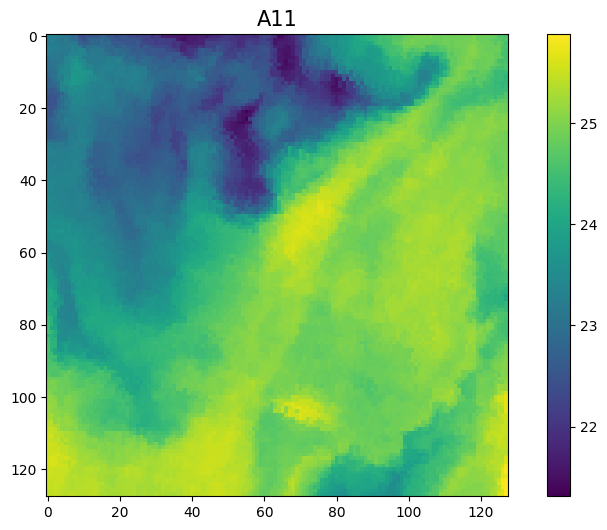

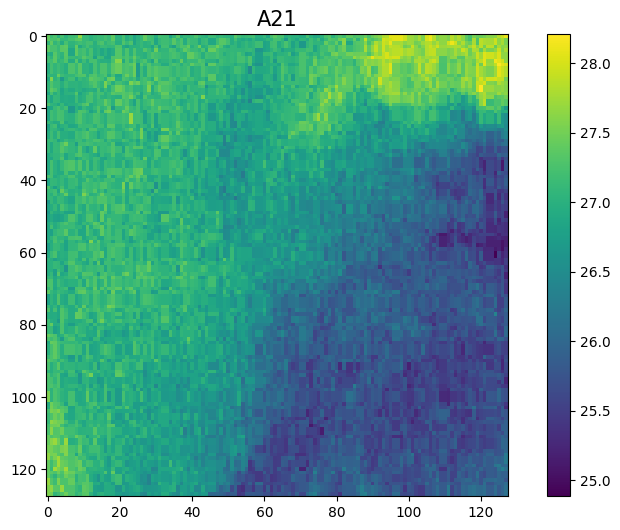

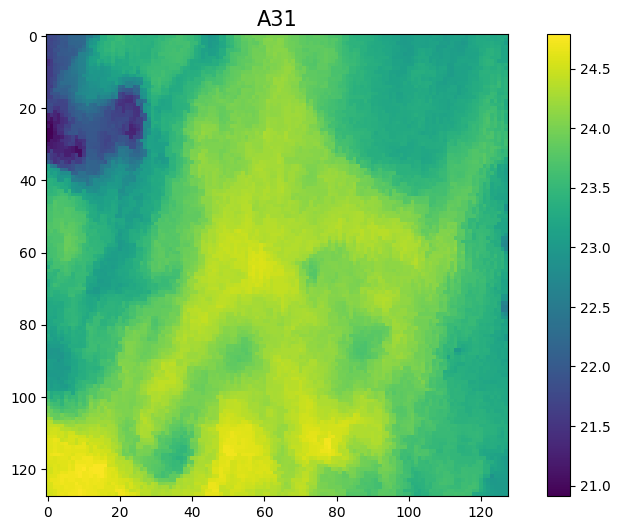

In [18]:
A11 = np.zeros((128,128))
A12 = np.zeros((128,128))
A13 = np.zeros((128,128))

A21 = np.zeros((128,128))
A22 = np.zeros((128,128))
A23 = np.zeros((128,128))

A31 = np.zeros((128,128))
A32 = np.zeros((128,128))
A33 = np.zeros((128,128))


A11 = mask1[1172:1300,280:408]
# A12 = kriging_twice(mask1[1072:1200,250:378])
# A13 = kriging_twice(mask1[772:900,230:358])
A21 = mask2[600:728,300:428]
# A22 = kriging_twice(mask2[772:900,300:428])
# A23 = kriging_twice(mask2[502:630,170:292], r=30)

A31 = kriging_twice(mask3[850-4:978-4,222:350])
#A3[A3==0] = np.mean(mask3[850-4:978-4,222:350][:-50,:])
# A32 = kriging_twice(mask3[1000:1128,372:500], r=40)
# A33 = kriging_twice(mask3[1030:1030+128,545:545+128], r=30)

ims(A11, 'A11')
# ims(A12, 'A12')
# ims(A13, 'A13')
ims(A21, 'A21')
# ims(A22, 'A22')
# ims(A23, 'A23')
ims(A31, 'A31')
# ims(A32, 'A32')
# ims(A33, 'A33')

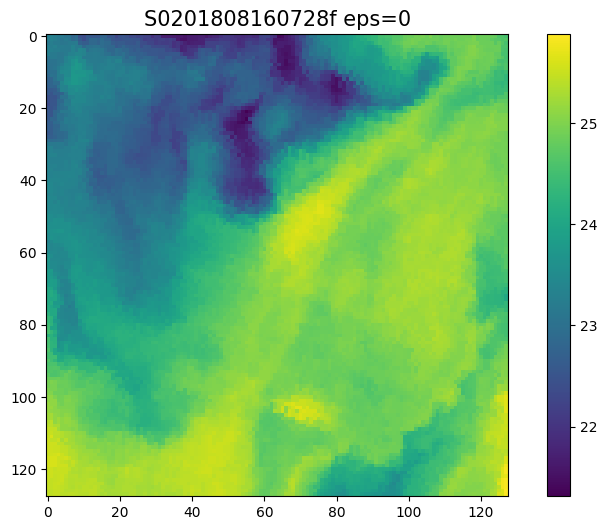

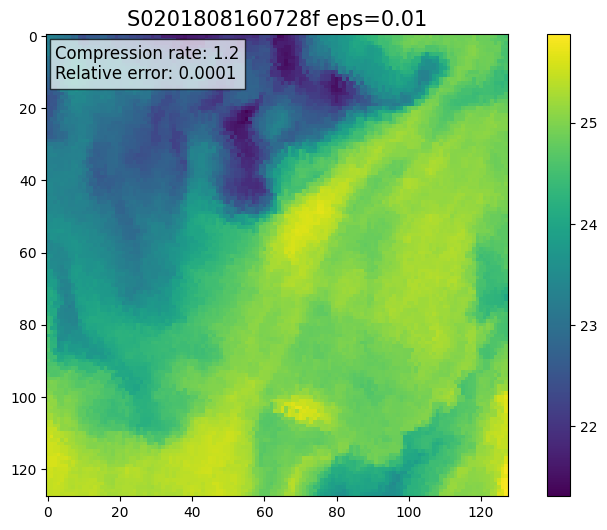

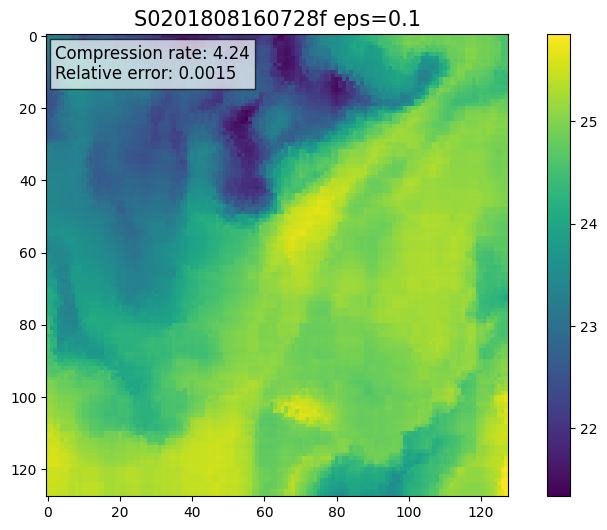

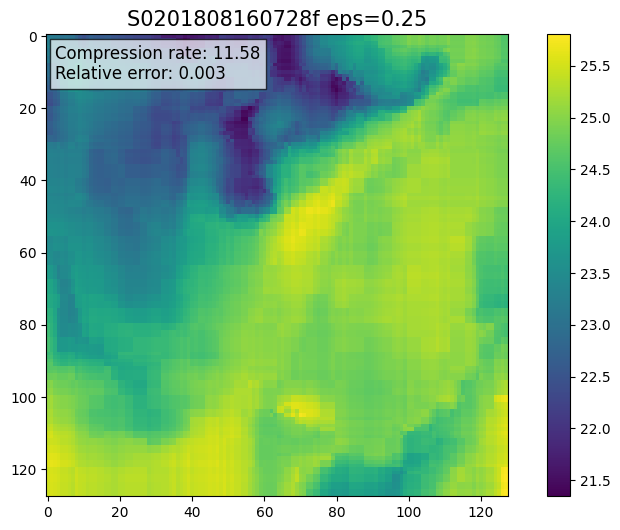

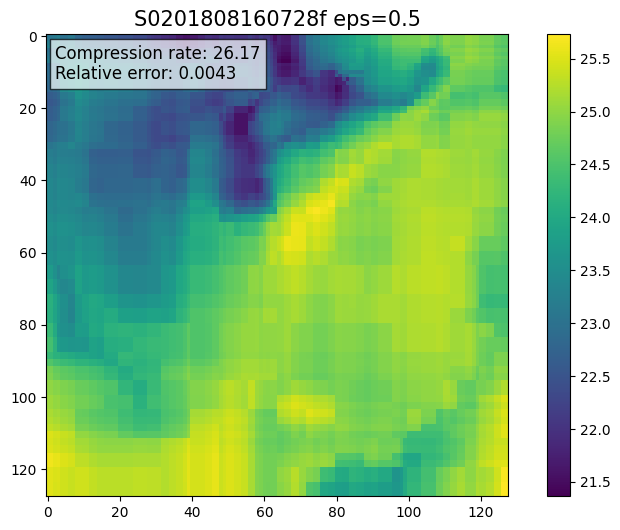

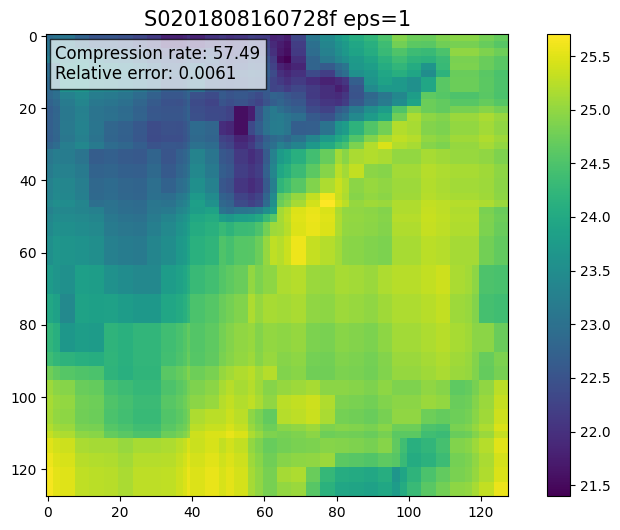

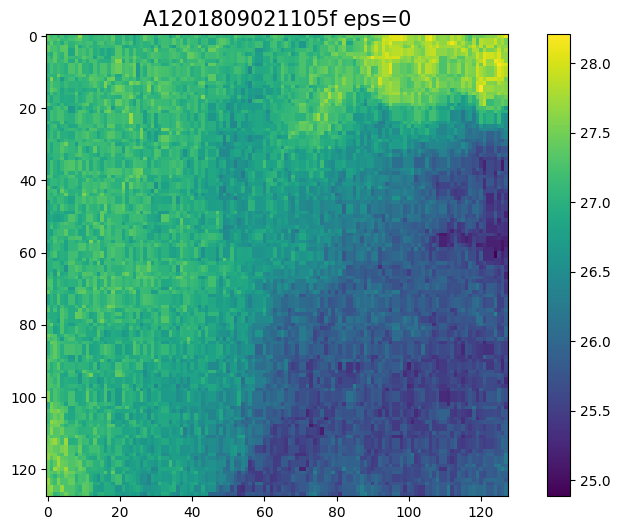

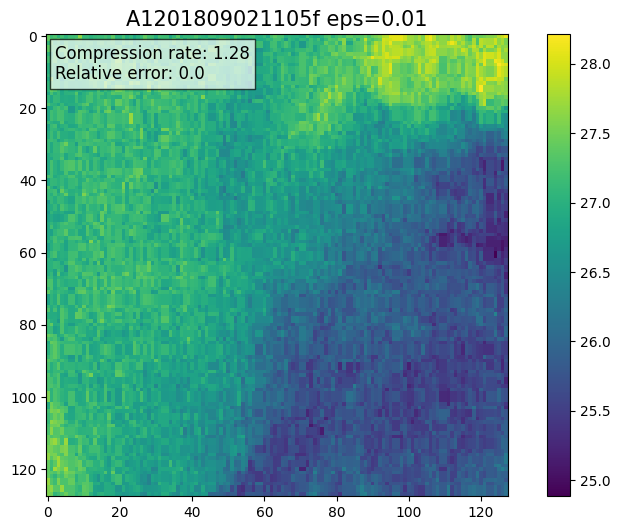

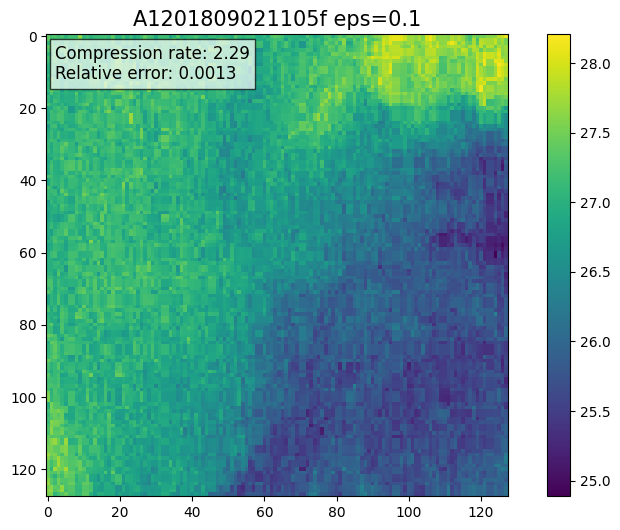

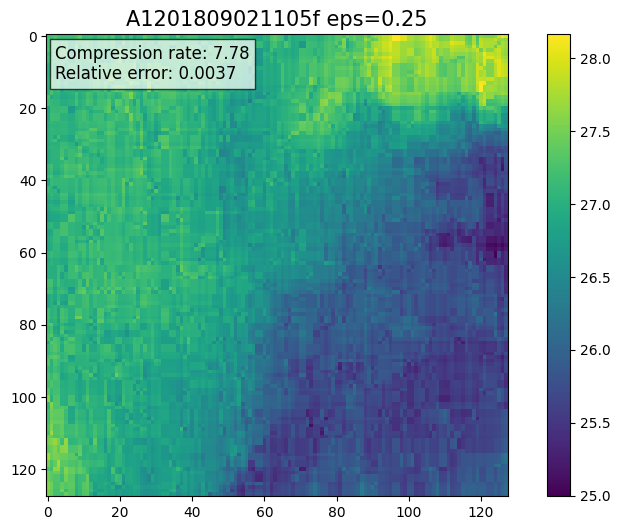

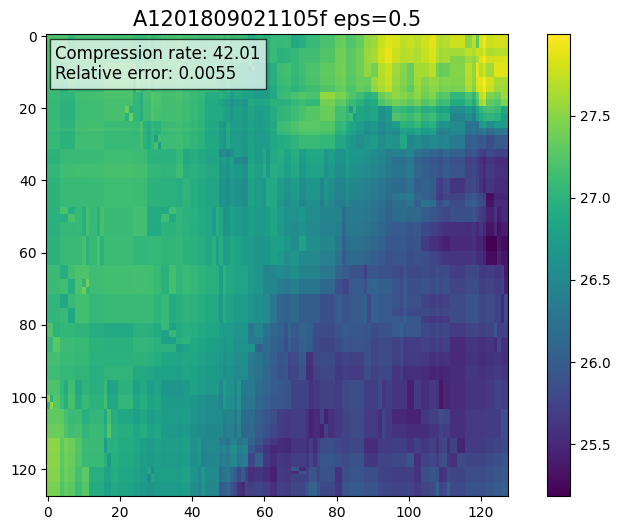

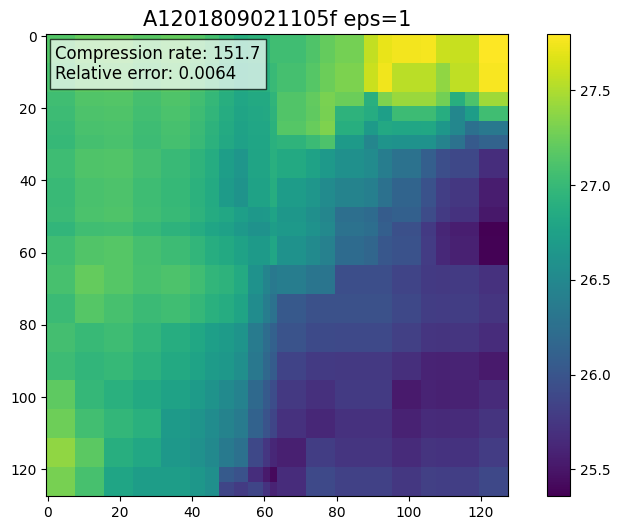

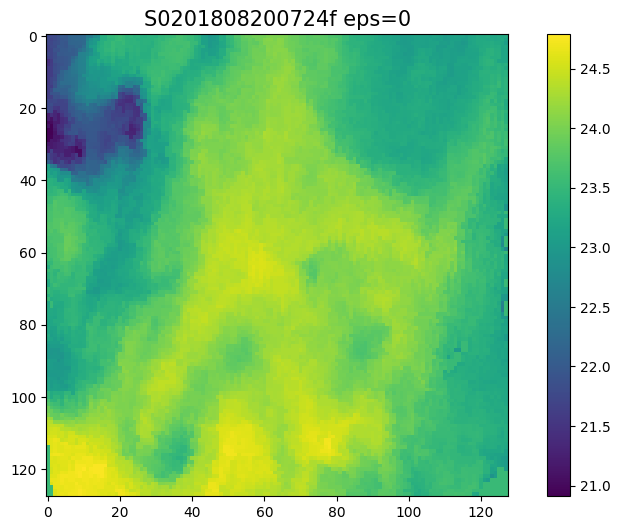

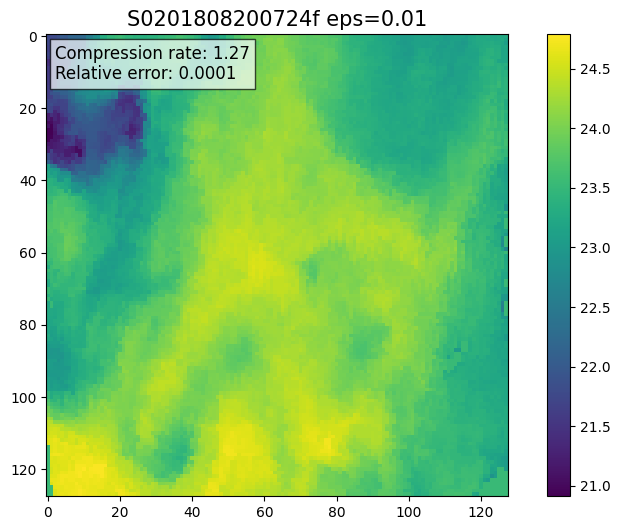

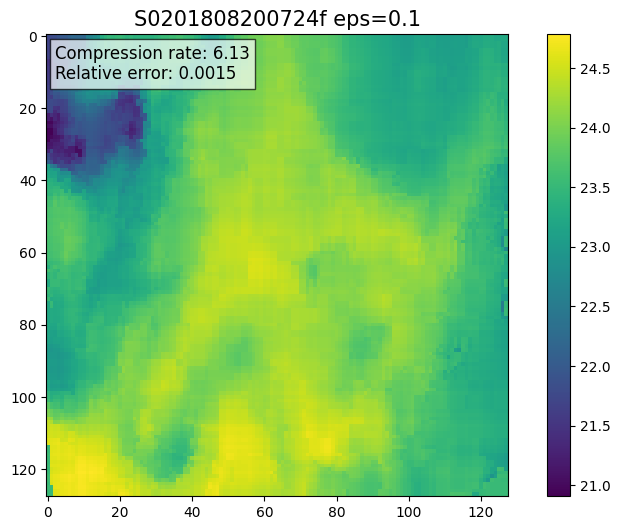

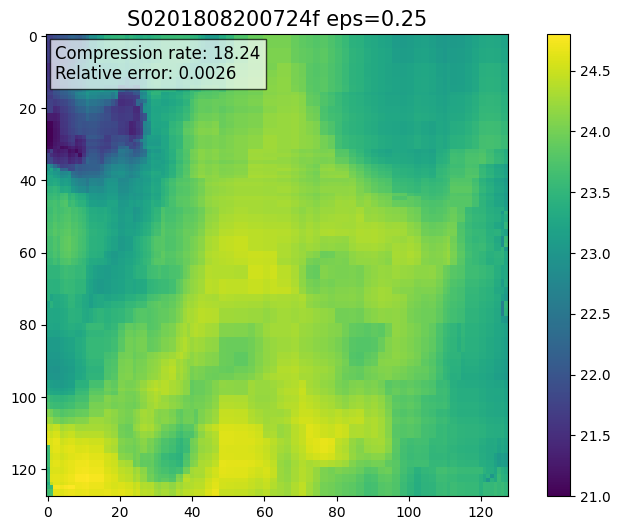

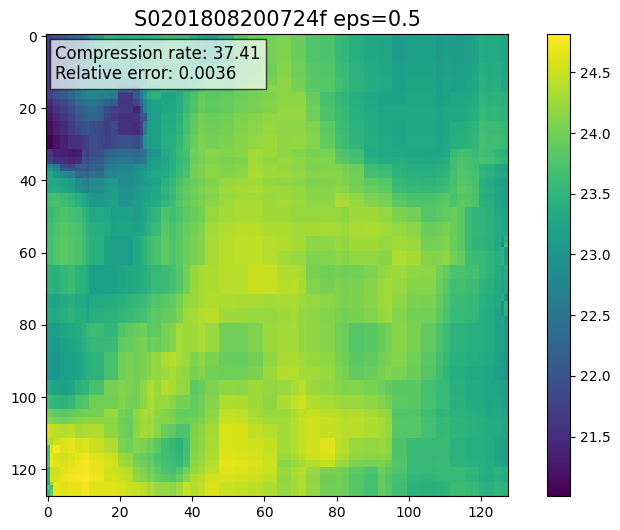

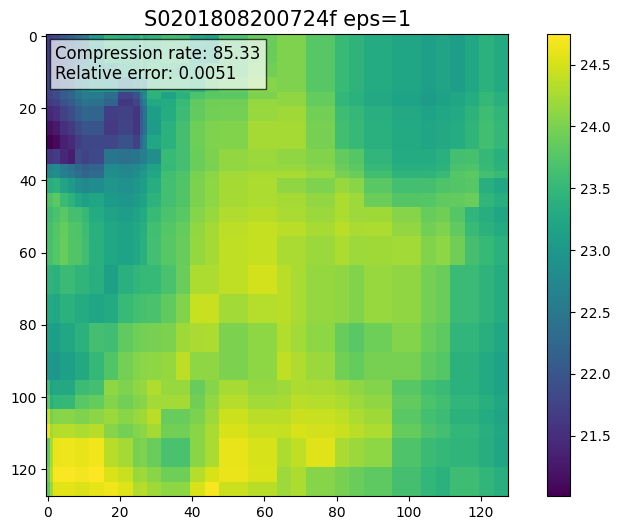

In [22]:
plot_compression(A1,H,file[0][:-4])
plot_compression(A2,H,file[1][:-4])
plot_compression(A3,H,file[2][:-4])

### Вейвлеты Добеши с помощью библиотеки pywt

In [54]:
def threshold(decomposed, thresh):
    thresh_decomposed = []
    zero_count = 0
    k =0
    for item in decomposed:
        thresh_decomposed.append(pywt.threshold(item,thresh, 'hard'))
        zero_count+= np.count_nonzero(thresh_decomposed[-1])
    for i in range(1,len(decomposed)):
        thresh_decomposed[i] = tuple(thresh_decomposed[i])
    return thresh_decomposed, zero_count

def compression_and_error(A, recomposed,zero_count):
    nonzeroA = np.count_nonzero(A)
    compression_rate = round(nonzeroA / zero_count,2)
    error = round(np.linalg.norm(A- recomposed)/np.linalg.norm(A),5)
    return compression_rate, error


def calc_compression(A,wavelet = 'db1',epsilon = [0.01,0.1,0.25,0.5,1]):
    cr = []
    err = []
    for eps in epsilon:
        decomposed = pywt.wavedec2(A,wavelet,mode='zero', level = pywt.dwtn_max_level(A.shape,wavelet)-1)
        decomposed_thr,zero_count =threshold(decomposed, thresh = eps)
        recomposed = pywt.waverec2(decomposed_thr,wavelet, mode='zero')
        compression_rate, error = compression_and_error(A, recomposed, zero_count)
        cr.append(compression_rate)
        err.append(error)
    return cr,err

    
def ims4(A,fig, ax, name = '', info = None):
    im = ax.imshow(A)
    plt.colorbar(ax=ax, mappable=im)
    if info!= None:
        ax.text(2, 18, f'Compression rate: {info[0]}\nRelative error: {info[1]}\neps: {info[2]}', fontsize = 12, 
        bbox = dict(facecolor = 'white', alpha = 0.7))
    if name != '':
        ax.set_title(name, fontsize = 15)
        fig.savefig(path+name,format = 'png')

def plot_compression(A,file_name,wavelet = 'db1',epsilon = [0.01,0.1,0.25,0.5,1]):
    #ims(A, name = f"{file_name} eps=0")
    fig,ax = plt.subplots(2,2,figsize=(16,16))
    fig.suptitle(file_name+' ' + wavelet,fontsize=25)
    ax.ravel()
    k=0
    ims4(A,fig,ax.flatten()[k], info=[0,0,0])
    for eps in epsilon:
        k+=1
        decomposed = pywt.wavedec2(A,wavelet,mode='zero', level = pywt.dwtn_max_level(A.shape,wavelet)-1)
        decomposed_thr,zero_count =threshold(decomposed, thresh = eps)
        recomposed = pywt.waverec2(decomposed_thr,wavelet, mode='zero')
        compression_rate, error = compression_and_error(A, recomposed, zero_count)
        ims4(recomposed,fig,ax.flatten()[k],info=[ compression_rate, error, eps])
    fig.savefig(file_name+' ' + wavelet)
        

def plot_comparison(cr,err, name,db_range = [1,2,3,4,5,10], right = 10, top = 2e-3):
    fig, ax = plt.subplots(figsize = (10,6))
    styles = {1:'-', 2:'-.',3:':',4:'--',5:'-*', 10:'-o'}
    ax.set_xlim(right= right)
    ax.set_ylim(top=top)
    ax.grid()
    for i in db_range:
        ax.plot(cr[f'db{i}'], err[f'db{i}'],styles[i] ,label = f'db{i}')
#         if i ==1:
#             ax.plot(cr[f'db{i}'], err[f'db{i}'],'-.' ,label = f'db{i}')
#         elif i ==2:
#             ax.plot(cr[f'db{i}'], err[f'db{i}'],'.' ,label = f'db{i}')
#         else:
#             ax.plot(cr[f'db{i}'], err[f'db{i}'],'-' ,label = f'db{i}')
    ax.set_title(name)
    ax.set_xlabel('Compression Rate')
    ax.set_ylabel('Relative error')
    ax.legend()
    fig.savefig('cr_re'+ name+'_')

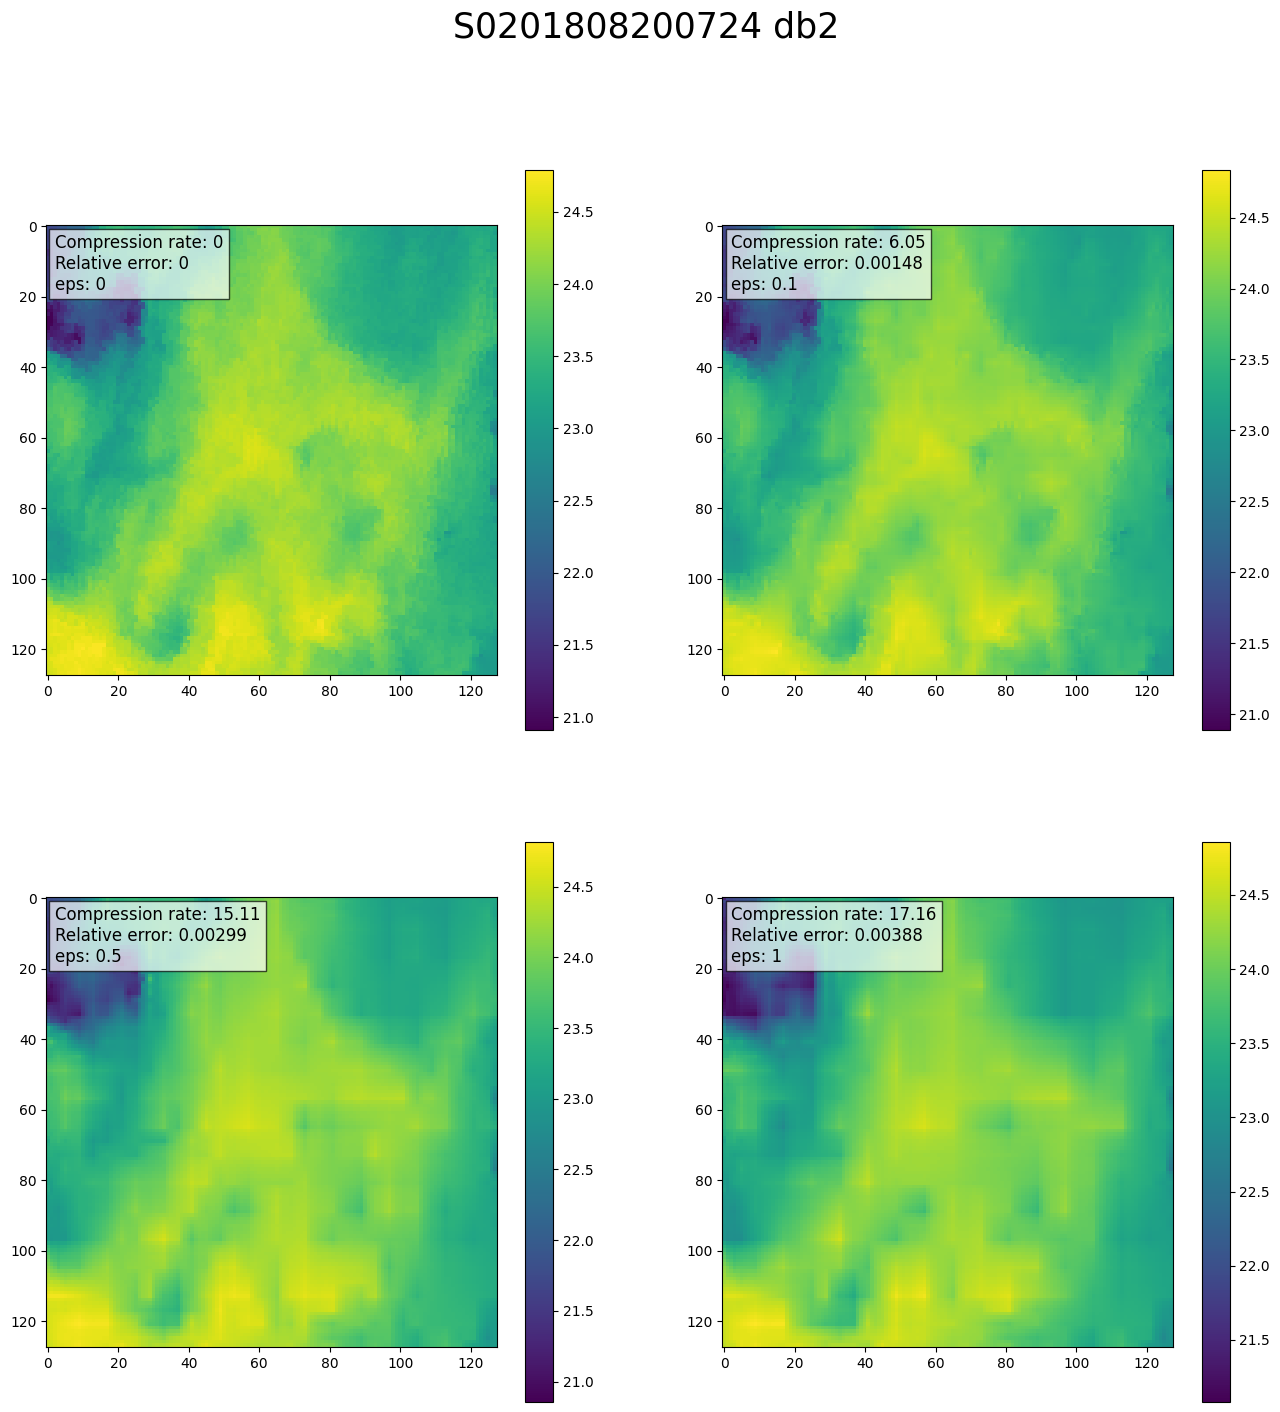

In [28]:
plot_compression(A31, 'S0201808200724', wavelet = 'db2', epsilon=[0.1, 0.5, 1])

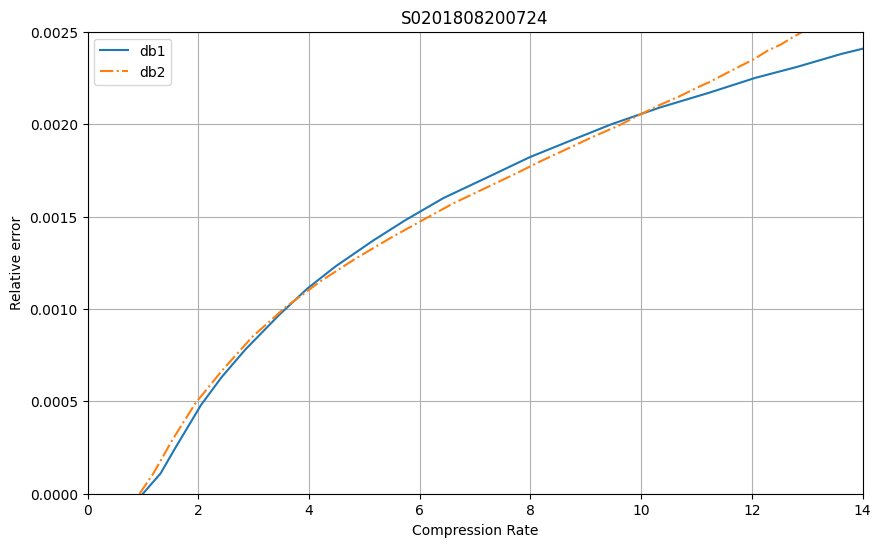

In [63]:
cr = dict()
err = dict()
for i in [1,2,3,4,5,10][:2]:
    cr[f'db{i}'], err[f'db{i}'] = calc_compression(A31, wavelet=f'db{i}', epsilon=np.arange(0,0.5, 0.01))
plot_comparison(cr,err,file[2][:-5],[1,2,3,4,5,10][:2], top = 2.5e-3, right =14)

In [282]:
decomposed = pywt.wavedec2(A31,'db8',mode='zero')

In [283]:
size = 0
for item in decomposed:
    size += np.array(item).size
size

24034

16384 16384 1.0


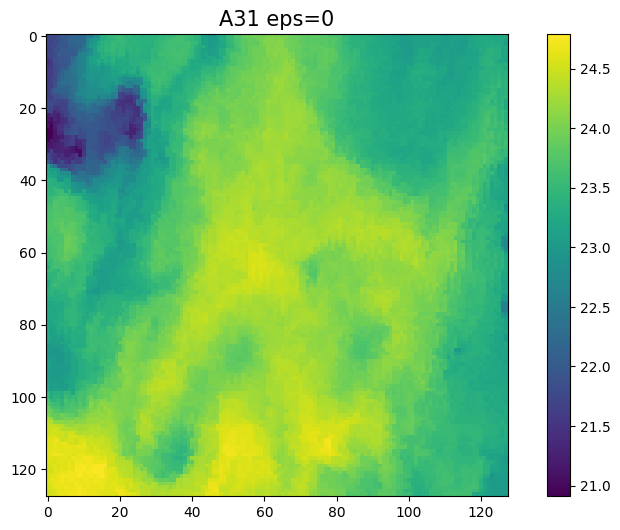

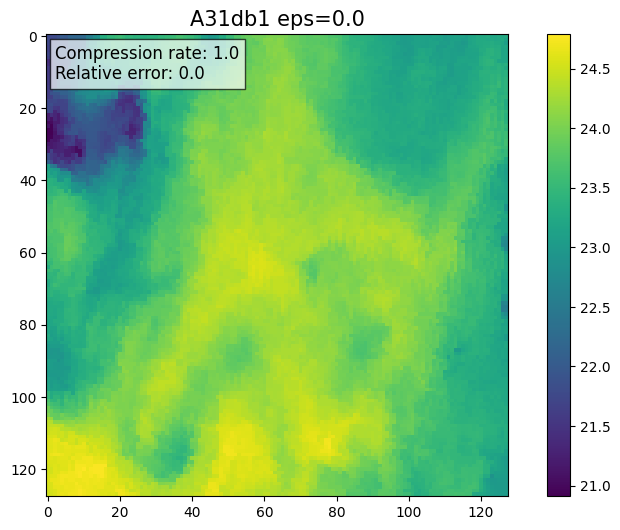

In [258]:
plot_compression(A31,'A31', wavelet='db1', epsilon=[0.00])

In [192]:
compression_and_error(A31,recomposed, zero_count)

(1.0, 0.04536602878224804)

In [ ]:
#                             -------------------
#                             |        |        |
#                             | cA(LL) | cH(LH) |
#                             |        |        |
# (cA, (cH, cV, cD))  <--->   -------------------
#                             |        |        |
#                             | cV(HL) | cD(HH) |
#                             |        |        |
#                             -------------------

In [299]:
B = H@A@H.T
eps = 1.
print(f"nonzero elem which more than {eps}:",np.count_nonzero(B[abs(B)>eps]))
print(f"total nonzero elem: {np.count_nonzero(A)}")
print(f"compression rate: {round(np.count_nonzero(A)/np.count_nonzero(B[abs(B)>eps]),2)}")
B[abs(B)<eps]=0
A_restored = H.T@B@H
print(f"Frobenius norm relation norm(A-A_restored)/norm(A): {round(np.linalg.norm((A-A_restored))/np.linalg.norm(A),4)}")
ims(A_restored)

nonzero elem which more than 1.0: 285
total nonzero elem: 16384
compression rate: 57.49
Frobenius norm relation norm(A-A_restored)/norm(A): 0.0061
